SIREN for Navier-Stokes
=======================
Notebook version of the "siren_navier_stokes_1214.py"



Sinusoidal Representation Networks that directly map (x,y,t) -> (u,v,p)

python siren_navier_stokes.py --data_path ./cylinder_nektar_wake.mat \
  --device cuda --seed 0 --Re 100 --test_t_idx 100 --n_train 2500 \
  --n_colloc 5000 --hidden_dim 256 --n_layers 4 --omega_0 30.0 \
  --steps 1000 --lr 1e-4 --w_pde 1.0 --save_path checkpoints/siren_ns.pt


"""

In [1]:
import os
import math
import argparse
import numpy as np
import scipy.io
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
def set_seed(seed=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


class SIRENLayer(nn.Module):
    def __init__(self, in_features, out_features, omega_0=30.0, is_first=False):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.linear = nn.Linear(in_features, out_features)
        
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / in_features, 1 / in_features)
            else:
                self.linear.weight.uniform_(
                    -math.sqrt(6 / in_features) / omega_0,
                    math.sqrt(6 / in_features) / omega_0
                )
    
    def forward(self, x):
        return torch.sin(self.omega_0 * self.linear(x))


class SIREN(nn.Module):
    def __init__(self, in_features=3, hidden_features=256, hidden_layers=4, 
                 out_features=3, omega_0=30.0):
        super().__init__()
        
        self.net = nn.ModuleList()
        self.net.append(SIRENLayer(in_features, hidden_features, 
                                   omega_0=omega_0, is_first=True))
        
        for _ in range(hidden_layers):
            self.net.append(SIRENLayer(hidden_features, hidden_features, 
                                      omega_0=omega_0, is_first=False))
        
        final_linear = nn.Linear(hidden_features, out_features)
        with torch.no_grad():
            final_linear.weight.uniform_(
                -math.sqrt(6 / hidden_features) / omega_0,
                math.sqrt(6 / hidden_features) / omega_0
            )
        self.net.append(final_linear)
    
    def forward(self, coords):
        """coords: (B, N, 3) -> (x, y, t)"""
        x = coords
        for i, layer in enumerate(self.net[:-1]):
            x = layer(x)
        x = self.net[-1](x)
        return x


class CylinderWakeData:
    def __init__(self, mat_path, seed=0):
        data = scipy.io.loadmat(mat_path)
        self.U_star = data["U_star"]
        self.p_star = data["p_star"]
        self.X_star = data["X_star"]
        self.t_star = data["t"]
        
        self.N = self.X_star.shape[0]
        self.T = self.t_star.shape[0]
        
        # Flatten
        XX = np.tile(self.X_star[:, 0:1], (1, self.T))
        YY = np.tile(self.X_star[:, 1:2], (1, self.T))
        TT = np.tile(self.t_star, (1, self.N)).T
        
        self.x = XX.flatten()[:, None]
        self.y = YY.flatten()[:, None]
        self.t = TT.flatten()[:, None]
        self.u = self.U_star[:, 0, :].flatten()[:, None]
        self.v = self.U_star[:, 1, :].flatten()[:, None]
        self.p = self.p_star.flatten()[:, None]
        
        self.NT = self.x.shape[0]
        self.rng = np.random.RandomState(seed)
    
    def get_training_data(self, n_train):
        idx = self.rng.choice(self.NT, n_train, replace=False)
        xyt = np.concatenate([self.x[idx], self.y[idx], self.t[idx]], axis=1)
        uvp = np.concatenate([self.u[idx], self.v[idx], self.p[idx]], axis=1)
        return xyt, uvp
    
    def get_snapshot(self, t_idx):
        x = self.X_star[:, 0:1]
        y = self.X_star[:, 1:2]
        t = np.full_like(x, self.t_star[t_idx, 0])
        u = self.U_star[:, 0, t_idx:t_idx+1]
        v = self.U_star[:, 1, t_idx:t_idx+1]
        p = self.p_star[:, t_idx:t_idx+1]
        xyt = np.concatenate([x, y, t], axis=1)
        uvp = np.concatenate([u, v, p], axis=1)
        return xyt, uvp


def ns_residuals(uvp, xyt, nu):
    """Compute Navier-Stokes residuals"""
    u = uvp[..., 0:1]
    v = uvp[..., 1:2]
    p = uvp[..., 2:3]
    
    grads_u = torch.autograd.grad(u, xyt, grad_outputs=torch.ones_like(u),
                                  create_graph=True, retain_graph=True)[0]
    grads_v = torch.autograd.grad(v, xyt, grad_outputs=torch.ones_like(v),
                                  create_graph=True, retain_graph=True)[0]
    grads_p = torch.autograd.grad(p, xyt, grad_outputs=torch.ones_like(p),
                                  create_graph=True, retain_graph=True)[0]
    
    u_x, u_y, u_t = grads_u[..., 0:1], grads_u[..., 1:2], grads_u[..., 2:3]
    v_x, v_y, v_t = grads_v[..., 0:1], grads_v[..., 1:2], grads_v[..., 2:3]
    p_x, p_y = grads_p[..., 0:1], grads_p[..., 1:2]
    
    u_xx = torch.autograd.grad(u_x, xyt, grad_outputs=torch.ones_like(u_x),
                              create_graph=True, retain_graph=True)[0][..., 0:1]
    u_yy = torch.autograd.grad(u_y, xyt, grad_outputs=torch.ones_like(u_y),
                              create_graph=True, retain_graph=True)[0][..., 1:2]
    v_xx = torch.autograd.grad(v_x, xyt, grad_outputs=torch.ones_like(v_x),
                              create_graph=True, retain_graph=True)[0][..., 0:1]
    v_yy = torch.autograd.grad(v_y, xyt, grad_outputs=torch.ones_like(v_y),
                              create_graph=True, retain_graph=True)[0][..., 1:2]
    
    r_u = u_t + u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
    r_v = v_t + u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)
    r_c = u_x + v_y
    
    return r_u, r_v, r_c


In [3]:
def plot_results(res, history, args, save_dir):
    """Create comprehensive result plots for SIREN"""
    os.makedirs(save_dir, exist_ok=True)
    
    # 1. Training curves
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    ax = axes[0, 0]
    ax.semilogy(history["step"], history["loss"])
    ax.set_title("Total Loss")
    ax.set_xlabel("Step")
    ax.grid(True, alpha=0.3)
    
    ax = axes[0, 1]
    ax.semilogy(history["step"], history["data_loss"], label="Data")
    ax.semilogy(history["step"], history["pde_loss"], label="PDE")
    ax.set_title("Loss Components")
    ax.set_xlabel("Step")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    ax = axes[1, 0]
    ax.semilogy(history["step"], history["test_mse"])
    ax.set_title("Test MSE")
    ax.set_xlabel("Step")
    ax.grid(True, alpha=0.3)
    
    ax = axes[1, 1]
    ax.text(0.5, 0.5, f"Final Test MSE:\n{history['test_mse'][-1]:.3e}",
            ha='center', va='center', fontsize=14, transform=ax.transAxes)
    ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_curves.png'), dpi=150, bbox_inches='tight')
    plt.close()
    
    # 2. Prediction visualization
    x = res["x"]
    y = res["y"]
    uvp_true = res["uvp_true"]
    uvp_pred = res["uvp_pred"]
    
    # Detect grid structure
    xu = np.unique(np.round(x, 10))
    yu = np.unique(np.round(y, 10))
    nx, ny = len(xu), len(yu)
    
    try:
        x_to_i = {val: i for i, val in enumerate(xu)}
        y_to_j = {val: j for j, val in enumerate(yu)}
        
        def to_grid(values):
            grid = np.full((ny, nx), np.nan)
            for xi, yi, val in zip(np.round(x, 10), np.round(y, 10), values):
                grid[y_to_j[yi], x_to_i[xi]] = val
            return grid
        
        is_grid = True
    except:
        is_grid = False
    
    fig, axes = plt.subplots(3, 3, figsize=(14, 10))
    
    for i, var in enumerate(['u', 'v', 'p']):
        true_val = uvp_true[:, i]
        pred_val = uvp_pred[:, i]
        err_val = np.abs(pred_val - true_val)
        
        if is_grid:
            true_grid = to_grid(true_val)
            pred_grid = to_grid(pred_val)
            err_grid = to_grid(err_val)
            extent = [xu.min(), xu.max(), yu.min(), yu.max()]
            
            ax = axes[i, 0]
            im = ax.imshow(true_grid, origin='lower', aspect='auto', 
                          extent=extent, cmap='viridis', interpolation='bilinear')
            ax.set_title(f'{var} (True)')
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            plt.colorbar(im, ax=ax)
            
            ax = axes[i, 1]
            im = ax.imshow(pred_grid, origin='lower', aspect='auto',
                          extent=extent, cmap='viridis', interpolation='bilinear')
            ax.set_title(f'{var} (Pred)')
            ax.set_xlabel('x')
            plt.colorbar(im, ax=ax)
            
            ax = axes[i, 2]
            im = ax.imshow(err_grid, origin='lower', aspect='auto',
                          extent=extent, cmap='hot', interpolation='bilinear')
            ax.set_title(f'{var} (Abs Error)')
            ax.set_xlabel('x')
            plt.colorbar(im, ax=ax)
        else:
            ax = axes[i, 0]
            sc = ax.scatter(x, y, c=true_val, s=3, cmap='viridis')
            ax.set_title(f'{var} (True)')
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            plt.colorbar(sc, ax=ax)
            
            ax = axes[i, 1]
            sc = ax.scatter(x, y, c=pred_val, s=3, cmap='viridis')
            ax.set_title(f'{var} (Pred)')
            ax.set_xlabel('x')
            plt.colorbar(sc, ax=ax)
            
            ax = axes[i, 2]
            sc = ax.scatter(x, y, c=err_val, s=3, cmap='hot')
            ax.set_title(f'{var} (Abs Error)')
            ax.set_xlabel('x')
            plt.colorbar(sc, ax=ax)
    
    plt.suptitle(f"SIREN | MSE={res['mse']:.3e} | t_index={args.test_t_idx}", y=0.995)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'predictions.png'), dpi=150, bbox_inches='tight')
    
    print(f"Saved plots to {save_dir}/")

In [4]:
def train_siren(args):
    device = torch.device(args.device)
    set_seed(args.seed)
    
    data = CylinderWakeData(args.data_path, seed=args.seed)
    nu = 1.0 / args.Re
    
    # Training data
    xyt_train, uvp_train = data.get_training_data(args.n_train)
    xyt_train = torch.tensor(xyt_train, dtype=torch.float32, device=device)
    uvp_train = torch.tensor(uvp_train, dtype=torch.float32, device=device)
    
    # Test data
    xyt_test, uvp_test = data.get_snapshot(args.test_t_idx)
    xyt_test = torch.tensor(xyt_test, dtype=torch.float32, device=device)
    uvp_test = torch.tensor(uvp_test, dtype=torch.float32, device=device)
    
    # Model
    model = SIREN(in_features=3, hidden_features=args.hidden_dim, 
                  hidden_layers=args.n_layers, out_features=3,
                  omega_0=args.omega_0).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, 
                                 weight_decay=args.weight_decay)
    
    n_params = sum(p.numel() for p in model.parameters())
    print(f"\nSIREN Training")
    print(f"Device: {device}")
    print(f"Parameters: {n_params:,}")
    print(f"Re={args.Re} -> nu={nu:.6f}")
    print(f"Training points: {args.n_train}")
    print(f"Test snapshot: t_idx={args.test_t_idx}")
    
    history = {"step": [], "loss": [], "data_loss": [], "pde_loss": [], 
               "test_mse": []}
    best_test = float('inf')
    
    for step in range(1, args.steps + 1):
        model.train()
        optimizer.zero_grad()
        
        # Data loss
        pred_train = model(xyt_train)
        loss_data = F.mse_loss(pred_train, uvp_train)
        
        # PDE loss
        if args.w_pde > 0:
            xyt_col, _ = data.get_training_data(args.n_colloc)
            xyt_col = torch.tensor(xyt_col, dtype=torch.float32, 
                                  device=device).requires_grad_(True)
            pred_col = model(xyt_col)
            r_u, r_v, r_c = ns_residuals(pred_col, xyt_col, nu)
            loss_pde = r_u.square().mean() + r_v.square().mean() + r_c.square().mean()
        else:
            loss_pde = torch.tensor(0.0, device=device)
        
        loss = loss_data + args.w_pde * loss_pde
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        if step % args.print_every == 0 or step == 1:
            model.eval()
            with torch.no_grad():
                pred_test = model(xyt_test)
                test_mse = F.mse_loss(pred_test, uvp_test).item()
            
            print(f"[{step:06d}] loss={loss.item():.3e} | "
                  f"data={loss_data.item():.3e} | pde={loss_pde.item():.3e} | "
                  f"test_mse={test_mse:.3e}")
            
            history["step"].append(step)
            history["loss"].append(loss.item())
            history["data_loss"].append(loss_data.item())
            history["pde_loss"].append(loss_pde.item())
            history["test_mse"].append(test_mse)
            
            if test_mse < best_test:
                best_test = test_mse
                if args.save_path:
                    os.makedirs(os.path.dirname(args.save_path), exist_ok=True)
                    torch.save({
                        'model': model.state_dict(),
                        'step': step,
                        'test_mse': best_test,
                        'history': history,
                    }, args.save_path)
    
    print(f"\nBest test MSE: {best_test:.3e}")
    
    # Final evaluation and plotting
    model.eval()
    with torch.no_grad():
        pred_test = model(xyt_test)
    
    res = {
        'x': xyt_test[:, 0].cpu().numpy(),
        'y': xyt_test[:, 1].cpu().numpy(),
        'uvp_true': uvp_test.cpu().numpy(),
        'uvp_pred': pred_test.cpu().numpy(),
        'mse': best_test
    }
    
    save_dir = os.path.join(os.path.dirname(args.save_path), 'siren_plots')
    plot_results(res, history, args, save_dir)
    
    return model, history


SIREN Training
Device: cuda
Parameters: 264,963
Re=100 -> nu=0.010000
Training points: 2500
Test snapshot: t_idx=100
[000001] loss=5.133e-01 | data=3.095e-01 | pde=2.038e-01 | test_mse=2.589e-01
[000500] loss=5.270e-02 | data=5.204e-02 | pde=6.563e-04 | test_mse=5.542e-02
[001000] loss=5.270e-02 | data=5.186e-02 | pde=8.464e-04 | test_mse=5.543e-02
[001500] loss=5.387e-02 | data=5.253e-02 | pde=1.339e-03 | test_mse=5.555e-02
[002000] loss=5.313e-02 | data=5.225e-02 | pde=8.873e-04 | test_mse=5.543e-02
[002500] loss=5.469e-02 | data=5.283e-02 | pde=1.860e-03 | test_mse=5.529e-02
[003000] loss=5.488e-02 | data=5.344e-02 | pde=1.434e-03 | test_mse=5.562e-02
[003500] loss=5.309e-02 | data=5.252e-02 | pde=5.661e-04 | test_mse=5.572e-02
[004000] loss=5.350e-02 | data=5.310e-02 | pde=4.002e-04 | test_mse=5.557e-02
[004500] loss=5.289e-02 | data=5.211e-02 | pde=7.884e-04 | test_mse=5.559e-02
[005000] loss=5.409e-02 | data=5.363e-02 | pde=4.654e-04 | test_mse=5.560e-02

Best test MSE: 5.529e-0

(SIREN(
   (net): ModuleList(
     (0): SIRENLayer(
       (linear): Linear(in_features=3, out_features=256, bias=True)
     )
     (1-4): 4 x SIRENLayer(
       (linear): Linear(in_features=256, out_features=256, bias=True)
     )
     (5): Linear(in_features=256, out_features=3, bias=True)
   )
 ),
 {'step': [1, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000],
  'loss': [0.5133013129234314,
   0.05269619822502136,
   0.052703920751810074,
   0.05386844277381897,
   0.05313291773200035,
   0.05468801409006119,
   0.05487585440278053,
   0.05308583006262779,
   0.053501907736063004,
   0.052893709391355515,
   0.054092887789011],
  'data_loss': [0.30946171283721924,
   0.05203987658023834,
   0.05185752734541893,
   0.052529726177453995,
   0.05224559083580971,
   0.05282807722687721,
   0.05344215780496597,
   0.05251972749829292,
   0.05310166999697685,
   0.052105315029621124,
   0.053627483546733856],
  'pde_loss': [0.20383960008621216,
   0.0006563231581822038,
   0.000

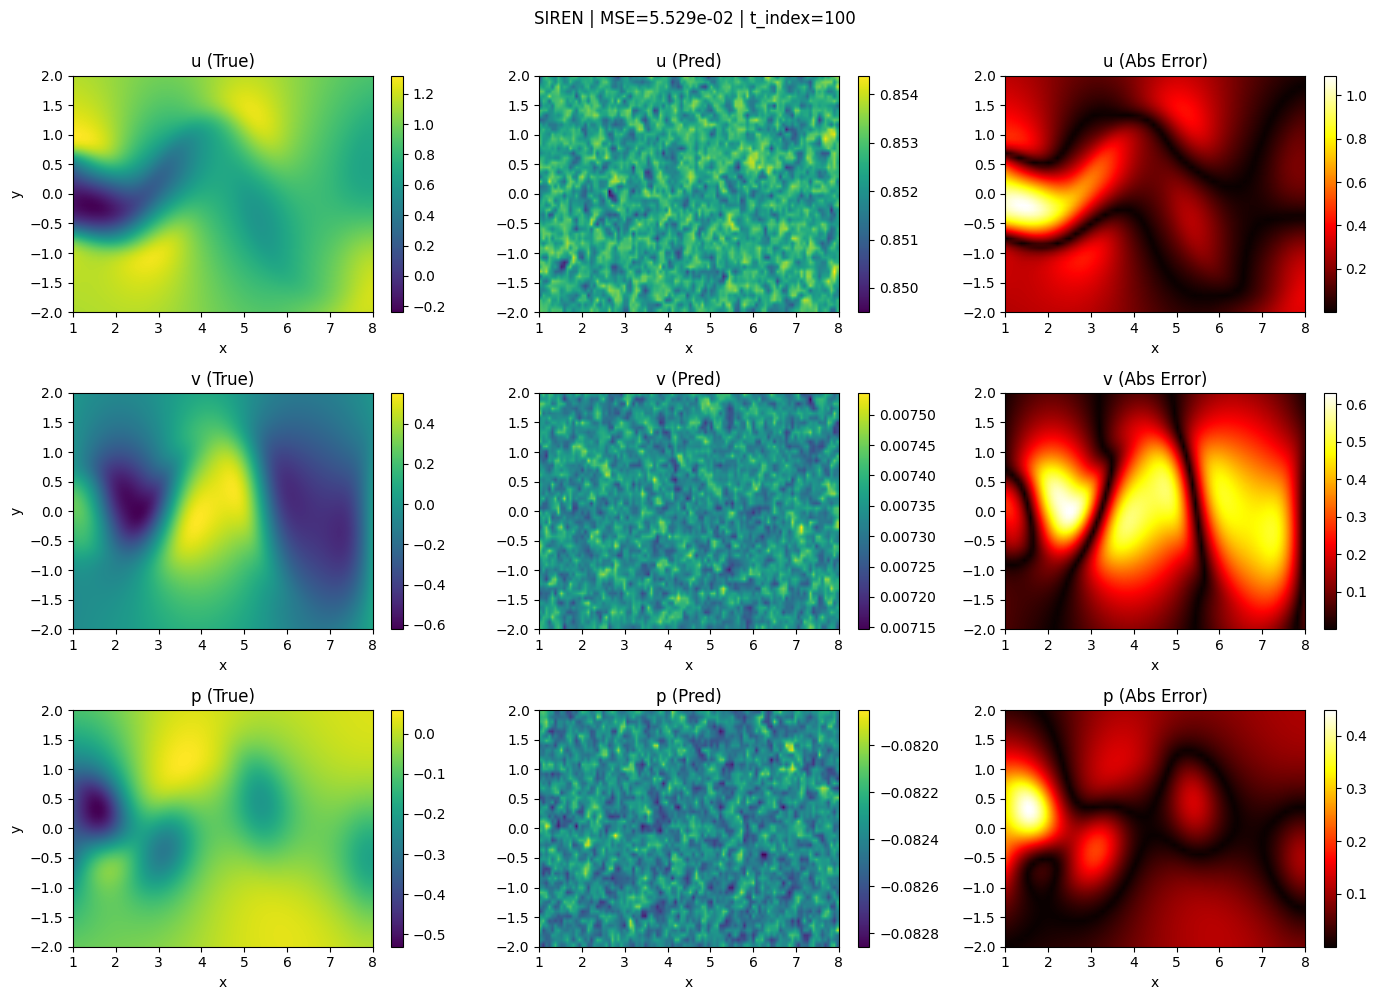

In [5]:
class Config:
    data_path = "./cylinder_nektar_wake.mat"
    device = "cuda"
    seed = 0
    Re = 100
    n_train = 2500
    n_colloc = 5000
    test_t_idx = 100
    hidden_dim = 256
    n_layers = 4
    omega_0 = 30
    steps = 5000
    lr = 1e-4
    weight_decay = 1e-4
    w_pde = 1
    print_every = 500
    save_path = "checkpoints/siren_ns.pt"
    
args = Config()


train_siren(args)